In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import scipy
from scipy import stats

import warnings
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from lib import *

Pipeline = pipeline.Pipeline
RegressionValidator = pipeline.RegressionValidator

DatasetProvider = provider.DatasetProvider
DatasetUploader = provider.DatasetUploader
ExpandedWindowIterator = subset_extraction.ExpandedWindowIterator
EntityIterator = subset_extraction.EntityIterator

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNet

errors = {}

In [3]:
CONFIG = {
    'validation_window': {
        'min_window': 18,
        'max_window': 32,
    },
    'training_window': {
        'min': 16
    },
    'FETCH_DATA': True,
    'dataset_paths': {
        'train': 'extracted_features.csv',
        'task_df': 'full_dataset.csv',
        'idx': 'idx.csv',
        'extended': 'extended_full_dataset.csv'
    }
}

### Dataset fetching

In [4]:
task_df = {}

task_df['test'] = pd.read_csv(CONFIG['dataset_paths']['task_df']).drop('Unnamed: 0', axis=1)
task_df['extended'] = pd.read_csv(CONFIG['dataset_paths']['extended']).drop('Unnamed: 0', axis=1)
train = pd.read_csv(CONFIG['dataset_paths']['train']).drop('Unnamed: 0', axis=1)
idx = pd.read_csv(CONFIG['dataset_paths']['idx']).drop('Unnamed: 0', axis=1)
target_test = task_df['test'].rename(columns={'month_block': 'window', 'item_cnt_month': 'target'})

In [5]:
from sklearn.metrics import mean_squared_error as mse

def get_features(date, train_df):
    return train_df[train_df.window == date].set_index(['id', 'window']).sort_index().drop('index', axis=1)
        
def get_target(date, target_vector):
    return target_vector.reset_index()[target_vector.reset_index().window == date].set_index(['id', 'window']).sort_index().drop('index', axis=1)

class RegressionValidator__transform:
    """
        Hardcoded for a while
    """
    def __init__(self, model, transform, back_transform,*args, **kwargs):
        self.model = model(**kwargs)
        self._transform = back_transform
        self._f_transform = transform
        
    def validate(self, cfg, joined_dataset, test_target):
        """
            Validate selected model on a dataset

            Input:

            1) 'joined_dataset' has the following format: ['id', 'window', feature_1, ... , target]
            2) 'test_target': ['id', 'window', 'target']
            3) 'cfg' is a dictionary containig ('min_window', 'max_window') in keys


            Out:
                - Residual statistics
        """
        train_df = joined_dataset.drop(['target'], axis=1)
        target_vector = joined_dataset.loc[:, ['id', 'window', 'target']]
        
        def get_features(date):
            return train_df[train_df.window == date].set_index(['id', 'window']).sort_index()
        
        current_date = cfg['min_window']
        max_date = cfg['max_window']
        
        errors = [
            [], [], [], []
        ]
        
        while current_date < max_date:
            current_features = get_features(current_date)
            validation_window = get_features(current_date + 1)
            
            current_target = get_target(current_date, target_vector)
            validation_target = get_target(current_date + 1, test_target)

            fitted = self.model.fit(current_features, current_target)

            tr_predictions = self.model.predict(validation_window)
            
            predictions = self._transform(tr_predictions)

            if predictions.transpose().shape[0] == 1:
                predictions = predictions.transpose()[0]
            else:
                predictions = predictions.transpose()
        
            errors[0].append(current_date)
            assert validation_target.loc[:,'target'].shape == predictions.shape, f'Shapes are pred:{validation_target.loc[:,"target"].shape} and truth:{predictions.shape}\nCurrent validation set: {current_date}'
            errors[1].append(mse(validation_target.loc[:,'target'].to_list(), predictions))
            
            report = pd.DataFrame({'true_values': validation_target.loc[:,'target'].to_list(), 'predicted': predictions})
            errors[2].append(report)
            inner_report = pd.DataFrame({'true_values': self._f_transform(validation_target.loc[:,'target'].to_numpy()), 'predicted': tr_predictions})
            errors[3].append(inner_report)
            
            current_date += 1
        
        return errors

In [6]:
def get_statistics(report):
    stat = report.copy()
    stat['residuals'] = stat['predicted'] - stat['true_values'] 
    stat['id'] = stat.index
    stat['abs_residuals'] = stat['residuals'].abs()
    stat['percentage'] = 2*(stat['residuals'])/(stat['true_values'] + stat['predicted'])
    return stat

def stat_info(errors):
    mean_residuals = pd.DataFrame({'abs_resid': [0 for _ in range(438)], 'resid': [0 for _ in range(438)]}, [i for i in range(438)])
    residual_series = None
    for _idx, report in enumerate(errors):
        residuals = get_statistics(report)
        mean_residuals['abs_resid'] += residuals['abs_residuals']
        mean_residuals['resid'] += residuals['residuals']
        resids = residuals['residuals'].reset_index()
        resids['window'] = _idx
        resids['true_value'] = residuals['true_values']
        resids.set_index(['index', 'window'], inplace=True)
        if residual_series is None:
            residual_series = resids
        else:
            residual_series = pd.concat([residual_series, resids])
    mean_residuals /= len(errors)
    return mean_residuals, residual_series, residuals

# Chapter 1
## Feature importance 

In [7]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

evaluation_forest = RandomForestRegressor(n_jobs=-1, max_depth=40)

In [8]:
split_last_x = train[train.window <= 32].drop(['target'], axis=1).set_index(['id', 'window'])
split_last_y = train[train.window <= 32].loc[:, ['id', 'window', 'target']].set_index(['id', 'window'])

In [9]:
feat_selector = BorutaPy(evaluation_forest, n_estimators='auto', verbose=0, random_state=1)

_ = feat_selector.fit(split_last_x.values, split_last_y.values)

split_last_x.columns[feat_selector.support_]

Index(['lag_2_mul', '_amin', 'last_12_mean', 'last_6_mean', 'last_2_mean',
       'last_observed'],
      dtype='object')

In [10]:
select = pd.DataFrame({'column_name': split_last_x.columns, 'importance': (feat_selector.ranking_)}).set_index('column_name').sort_values('importance', ascending=False)

In [11]:
select.tail(15).index.tolist()

['time',
 'lag_4_mul',
 '90_percentile',
 'lag_1_mul',
 'lag_12_mul',
 '_mean',
 'month_number',
 'lag_3_mul',
 '75_percentile',
 'last_2_mean',
 'last_6_mean',
 'last_observed',
 'last_12_mean',
 '_amin',
 'lag_2_mul']

<AxesSubplot:xlabel='importance', ylabel='column_name'>

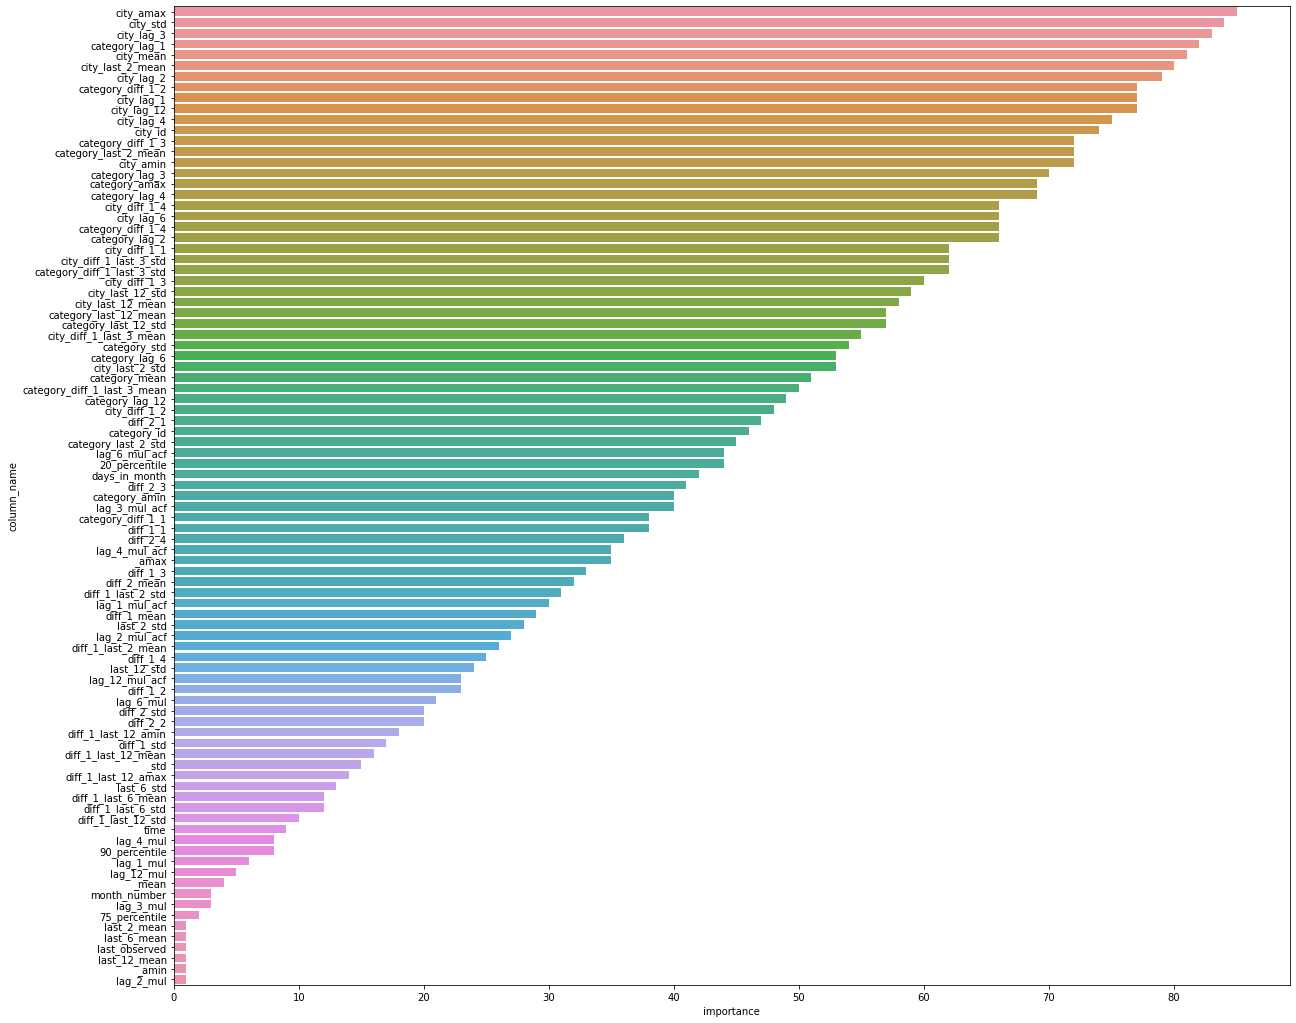

In [12]:
_, axs = plt.subplots(1, 1, figsize=(20, 18))

sns.barplot(data=select.reset_index(), x='importance', y='column_name', ax=axs)

# Chapter 2
## Evaluating feature minimum 

In [13]:
def gaussian_test(dataset):
    from scipy.stats import anderson

    result = anderson(dataset)

    print('stat=%.3f' % (result.statistic))
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < cv:
            print('Probably Gaussian at the %.1f%% level' % (sl))
        else:
            print('Probably not Gaussian at the %.1f%% level' % (sl))

Validation tuning

<AxesSubplot:>

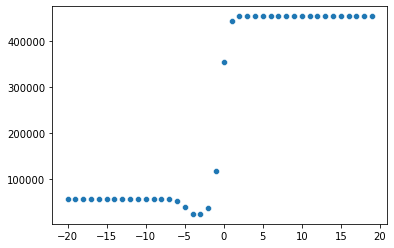

In [14]:
lis = [[], []]

for alpha_ in range(-20, 20):
    validator_lin = RegressionValidator(ElasticNet, l1_ratio=0.5, alpha=10**(alpha_), normalize=True)
    # validator_lin = RegressionValidator__transform(ElasticNet, log_back_tr, l1_ratio=0.5 + alpha_/40, alpha=10**(-3.7))

    err = validator_lin.validate(CONFIG['validation_window'], train, target_test)

    lis[0].append(alpha_)
    lis[1].append(np.mean(err[1]))

sns.scatterplot(*lis)

In [15]:
def get_feature_subset(df, columns):
    return df.loc[:,columns]

23042.82569199653

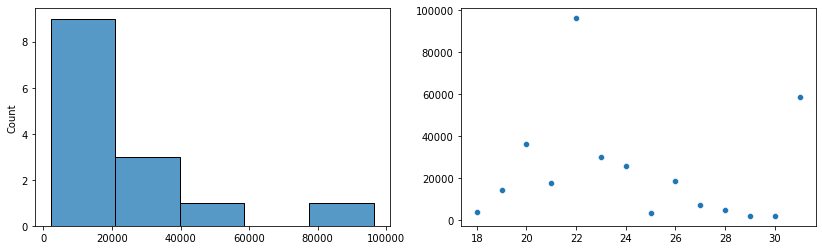

In [16]:
validator_lin = RegressionValidator(ElasticNet, l1_ratio=0.5, alpha=2.1e-4, normalize=True)
errors['elastic'] = validator_lin.validate(CONFIG['validation_window'], train, target_test)

_, axs = plt.subplots(1, 2, figsize=(14, 4))

sns.scatterplot(x=errors['elastic'][0], y=errors['elastic'][1], ax=axs[1])
sns.histplot(errors['elastic'][1], ax=axs[0])

np.mean(errors['elastic'][1])

In [17]:
proceed_residuals = {}

proceed_residuals['elastic'] = stat_info(errors['elastic'][2])

<AxesSubplot:xlabel='residuals', ylabel='Count'>

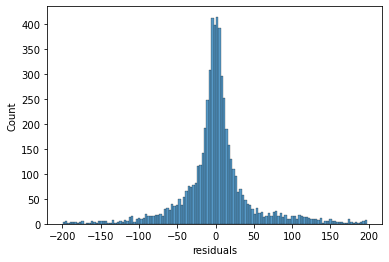

In [18]:
stable_residual_interval = proceed_residuals['elastic'][1].reset_index().rename(columns={'index': 'id'}).merge(idx)
stable_residual_interval['abs_residuals'] = abs(stable_residual_interval['residuals'])
sns.histplot(data=stable_residual_interval[stable_residual_interval.abs_residuals < 200], x='residuals')

In [19]:
# sns.jointplot(data=proceed_residuals['elastic'][1].reset_index(), x='true_value', y='residuals', hue='window')
# sns.lmplot(data=proceed_residuals['elastic'][1].reset_index(), x='true_value', y='residuals', hue='window')

Now lets check minimal subset 

In [143]:
minimal_subset_rfr = {}
columns = {}

index = ['id', 'window', 'target']

feature_len_list = [6, 8, 10, 12, 15, 17, 20, 22, 25, 27, 30, 32, 35, 37, 40, 42]

for i in feature_len_list:
    columns[f'40_depth_top_{i}'] = index + select.tail(i).index.tolist()
    minimal_subset_rfr[f'40_depth_top_{i}'] = get_feature_subset(train, columns[f'40_depth_top_{i}'])

In [21]:
alphas = {
    '40_depth_top_6': 1e-3,
    '40_depth_top_8': 1e-4,
    '40_depth_top_10': 1e-4,
    '40_depth_top_12': 1e-4,
    '40_depth_top_15': 1e-4,
    '40_depth_top_17': 1e-4,
    '40_depth_top_20': 1e-4,
    '40_depth_top_22': 1e-4,
    '40_depth_top_25': 1e-4,
    '40_depth_top_30': 1e-3,
    '40_depth_top_35': 1e-3,
}

In [22]:
current_subset = '40_depth_top_22'

<AxesSubplot:>

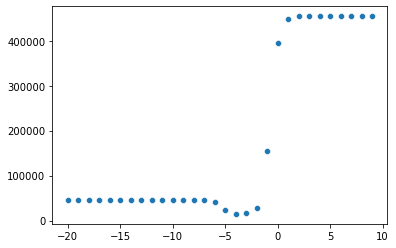

In [23]:
lis = [[], []]

for alpha_ in range(-20, 10):
    validator_lin = RegressionValidator(ElasticNet, l1_ratio=0.5, alpha=10**(alpha_), normalize=True)
    # validator_lin = RegressionValidator__transform(ElasticNet, log_back_tr, l1_ratio=0.5 + alpha_/40, alpha=10**(-3.7))

    err = validator_lin.validate(CONFIG['validation_window'], minimal_subset_rfr[current_subset], target_test)

    lis[0].append(alpha_)
    lis[1].append(np.mean(err[1]))

sns.scatterplot(*lis)

14722.689200936205

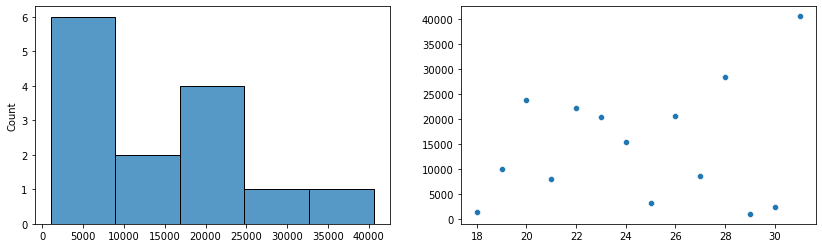

In [24]:
validator_lin = RegressionValidator(ElasticNet, l1_ratio=0.5, alpha=alphas[current_subset], normalize=True)
errors[current_subset] = validator_lin.validate(CONFIG['validation_window'], minimal_subset_rfr[current_subset], target_test)

_, axs = plt.subplots(1, 2, figsize=(14, 4))

sns.scatterplot(x=errors[current_subset][0], y=errors[current_subset][1], ax=axs[1])
sns.histplot(errors[current_subset][1], ax=axs[0])

np.mean(errors[current_subset][1])

Ох и чудеса чудесные

In [176]:
# feature_error_dynamic = {}

# for i in feature_len_list:
#     feature_error_dynamic[i] = np.mean(errors[f'40_depth_top_{i}'][1])

In [26]:
feature_error_dynamic = {6: 15447.344119433075,
 8: 12826.221475577146,
 10: 13531.901310000816,
 12: 13410.876456583786,
 15: 13531.901310000816,
 17: 12546.61405008083,
 20: 14928.866637791602,
 22: 12421.865022838481,
 25: 14303.276170872148,
 30: 19815.32808169234,
 35: 21823.368167402055}

<AxesSubplot:>

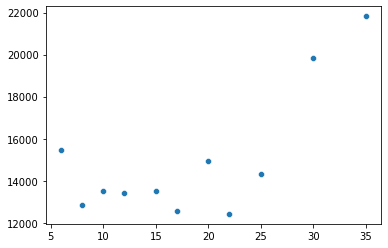

In [27]:
sns.scatterplot(x=feature_error_dynamic.keys(), y=feature_error_dynamic.values())

As we see num of features less than 30 is pretty good in predictions

### Minimum is in 22

Let's take a look on them

In [28]:
select.tail(22)

,importance
column_name,
diff_1_last_12_mean,16
_std,15
diff_1_last_12_amax,14
last_6_std,13
diff_1_last_6_mean,12
diff_1_last_6_std,12
diff_1_last_12_std,10
time,9
lag_4_mul,8


Our prdiction is a linear combination of 

* 4 last lags
* [12, 6] month lags are also important 
* Mean of series
* Percentile are also important (but not 20%)
* Time based trend is important

# Chapter 3

## Future exploration

In [169]:
current_subset = f'40_depth_top_10'
train_baseline = minimal_subset_rfr[current_subset]

In [170]:
train_baseline

,id,window,target,diff_2_4,lag_4_mul_acf,_amax,diff_1_3,diff_2_mean,diff_1_last_2_std,lag_1_mul_acf,...,_mean,month_number,lag_3_mul,75_percentile,last_2_mean,last_6_mean,last_observed,last_12_mean,_amin,lag_2_mul
0,0.0,13.0,43.0,5.0,-2.137174,113.0,79.0,3.071429,38.0,11.127566,...,47.071429,1.0,34.0,-8.872727,65.5,57.000000,75.0,45.916667,22.0,113.0
1,1.0,13.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
2,2.0,13.0,39.0,34.0,-0.884331,74.0,30.0,4.214286,56.0,1.288605,...,21.571429,1.0,44.0,-45.000000,31.0,35.833333,54.0,22.916667,5.0,74.0
3,3.0,13.0,407.0,86.0,38.050997,554.0,273.0,6.571429,75.0,166.651751,...,306.000000,1.0,281.0,-1165.000000,380.0,389.833333,372.0,326.000000,132.0,554.0
4,4.0,13.0,187.0,46.0,-118.184429,263.0,-63.0,8.785714,22.5,6.571232,...,203.214286,1.0,259.0,-467.000000,157.0,207.666667,159.0,203.166667,126.0,196.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,433.0,32.0,87.0,-40.0,63.961824,256.0,28.0,-0.303030,2.5,60.375418,...,142.060606,8.0,77.0,-617.120000,73.0,88.166667,64.0,99.750000,64.0,105.0
8756,434.0,32.0,98.0,63.0,-23.981487,397.0,26.0,-1.242424,28.0,76.404680,...,191.757576,8.0,182.0,-573.800000,156.0,158.666667,120.0,207.666667,120.0,208.0
8757,435.0,32.0,14.0,-2.0,3.581458,61.0,8.0,0.636364,4.0,7.634394,...,27.242424,8.0,9.0,-111.333333,12.0,12.500000,13.0,17.750000,9.0,17.0
8758,436.0,32.0,12.0,3.0,7.003432,46.0,20.0,0.212121,11.0,14.516892,...,10.696970,8.0,10.0,-187.533333,23.0,19.666667,28.0,24.250000,0.0,30.0


## Let's rebuild our validation system

### We will make validations among all windows using all previous windows to perform

In [171]:
def get_features(min_date, max_date, train_df):
    return train_df[(train_df.window >= min_date) & (train_df.window <= max_date)].set_index(['id', 'window']).sort_index()
        
def get_target(min_date, max_date, target_vector):
    return target_vector.reset_index()[(target_vector.reset_index().window >= min_date) & (target_vector.reset_index().window <= max_date)].set_index(['id', 'window']).sort_index().drop('index', axis=1)

class NEW_RegressionValidator:
    """
        Hardcoded for a while
    """
    def __init__(self, model, *args, **kwargs):
        self.model = model(**kwargs)
        
    def validate(self, cfg, joined_dataset, test_target):
        """
            Validate selected model on a dataset

            Input:

            1) 'joined_dataset' has the following format: ['id', 'window', feature_1, ... , target]
            2) 'test_target': ['id', 'window', 'target']
            3) 'cfg' is a dictionary containig ('min_window', 'max_window') in keys


            Out:
                - Residual statistics
        """
        train_df = joined_dataset.drop(['target'], axis=1)
        target_vector = joined_dataset.loc[:, ['id', 'window', 'target']]
        
        
        current_date = cfg['min_window']
        max_date = cfg['max_window']
        min_date = 13
        
        errors = [
            [], [], []
        ]

        while current_date < max_date:
            current_features = get_features(min_date, current_date, train_df)
            current_target = get_target(min_date, current_date, target_vector)
            
            validation_window = get_features(current_date + 1, current_date + 1, train_df)
            validation_target = get_target(current_date + 1, current_date + 1, test_target)

            fitted = self.model.fit(current_features, current_target)

            predictions = self.model.predict(validation_window)
            
            if predictions.transpose().shape[0] == 1:
                predictions = predictions.transpose()[0]
            else:
                predictions = predictions.transpose()
        
            errors[0].append(current_date)
            assert validation_target.loc[:,'target'].shape == predictions.shape, f'Shapes are pred:{validation_target.loc[:,"target"].shape} and truth:{predictions.shape}\nCurrent validation set: {current_date}'
            errors[1].append(mse(validation_target.loc[:,'target'].to_list(), predictions))
            
            report = pd.DataFrame({'true_values': validation_target.loc[:,'target'].to_list(), 'predicted': predictions})
            errors[2].append(report)
            
            current_date += 1
        
        return errors

<AxesSubplot:>

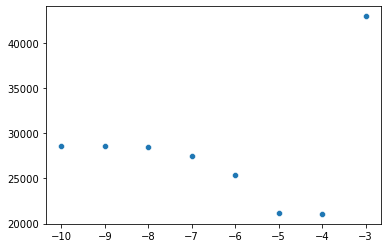

In [172]:
lis = [[], []]

for alpha_ in range(-10, -2):
    validator_lin = NEW_RegressionValidator(ElasticNet, l1_ratio=0.5, alpha=10**(alpha_), normalize=True)
    
    err = validator_lin.validate(CONFIG['validation_window'], train_baseline, target_test)

    lis[0].append(alpha_)
    lis[1].append(np.mean(err[1]))

sns.scatterplot(*lis)

21065.24070782746

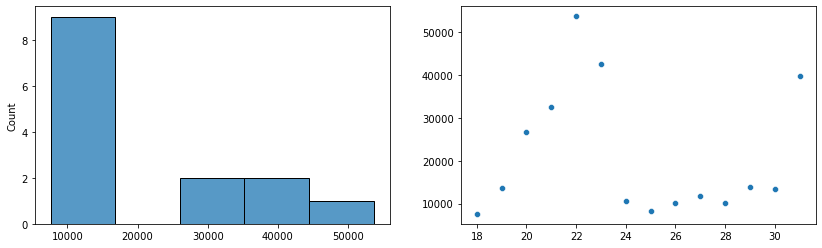

In [175]:
validator_lin = NEW_RegressionValidator(ElasticNet, l1_ratio=0.5, alpha=1e-4, normalize=True)
errors[current_subset] = validator_lin.validate(CONFIG['validation_window'], train_baseline, target_test)

_, axs = plt.subplots(1, 2, figsize=(14, 4))

sns.scatterplot(x=errors[current_subset][0], y=errors[current_subset][1], ax=axs[1])
sns.histplot(errors[current_subset][1], ax=axs[0])

np.mean(errors[current_subset][1])

In [180]:
# feature_error_dynamic = {}

# for i in feature_len_list:
#     feature_error_dynamic[i] = np.mean(errors[f'40_depth_top_{i}'][1])

feature_error_dynamic = {6: 15352.479840320386,
 8: 14985.055797105359,
 10: 14399.676569392792,
 12: 15216.850310055097,
 15: 16767.734434526574,
 17: 19292.82132688059,
 20: 19991.23318234177,
 22: 18527.01783305987,
 25: 18819.943786502994,
 27: 18334.30490611608,
 30: 19074.247593819007,
 32: 19619.2720669705,
 35: 19059.93439666207,
 37: 20433.7727310744,
 40: 20537.10147774968,
 42: 21065.24070782746}

<AxesSubplot:>

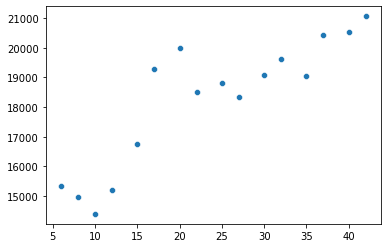

In [181]:
sns.scatterplot(x=feature_error_dynamic.keys(), y=feature_error_dynamic.values())

## New validation makes top 10 feature set as the most performant

## Basic residual exploration

In [182]:
proceed_residuals = {}

proceed_residuals['40_depth_top_10'] = stat_info(errors['40_depth_top_10'][2])

<AxesSubplot:xlabel='residuals', ylabel='Count'>

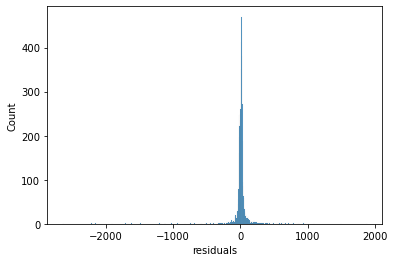

In [184]:
stable_residual_interval = proceed_residuals['40_depth_top_10'][1].reset_index().rename(columns={'index': 'id'}).merge(idx)
stable_residual_interval['abs_residuals'] = abs(stable_residual_interval['residuals'])
sns.histplot(data=stable_residual_interval, x='residuals')

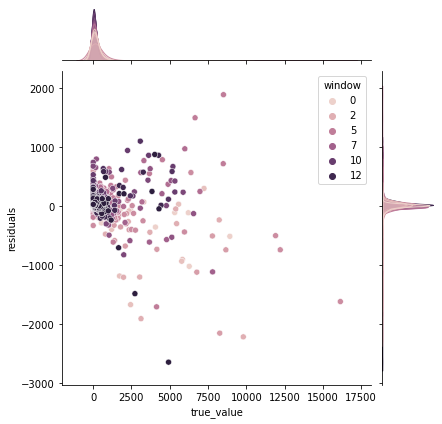

In [188]:
sns.jointplot(data=proceed_residuals['40_depth_top_10'][1].reset_index(), x='true_value', y='residuals', hue='window')

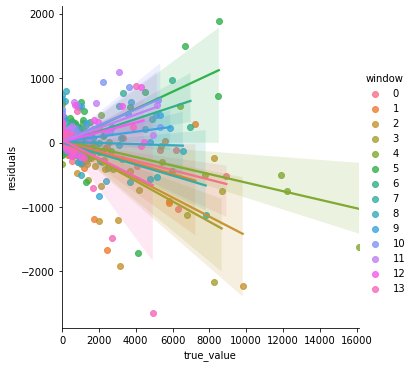

In [189]:
sns.lmplot(data=proceed_residuals['40_depth_top_10'][1].reset_index(), x='true_value', y='residuals', hue='window')